<font size="8">Trace Analysis Examples</font>
<br>
<font size="5">Tasks Latencies</font>
<br>
<hr>

# Import Required Modules

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

In [2]:
# Generate plots inline
%matplotlib inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Support for workload generation
from wlgen import RTA, Ramp

# Support for trace analysis
from trace import Trace
from trace_analysis import TraceAnalysis

# Support for plotting
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import trappy

# Target Configuration

In [3]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"    : 'linux',
    "board"       : 'juno',
    "host"        : '192.168.0.1',

    # Folder where all the results will be collected
    "results_dir" : "TraceAnalysis_TaskLatencies",

    # Define devlib modules to load
    "exclude_modules" : [ 'hwmon' ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
        "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
        ],
        
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'rt-app' ],
    
    # Comment this line to calibrate RTApp in your own platform
    "rtapp-calib" :  {"0": 360, "1": 142, "2": 138, "3": 352, "4": 352, "5": 353},
}

In [4]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

10:23:42  INFO    :         Target - Using base path: /home/derkling/Code/lisa
10:23:42  INFO    :         Target - Loading custom (inline) target configuration
10:23:42  INFO    :         Target - Devlib modules to load: ['bl', 'cpufreq']
10:23:42  INFO    :         Target - Connecting linux target:
10:23:42  INFO    :         Target -   username : root
10:23:42  INFO    :         Target -       host : 192.168.0.1
10:23:42  INFO    :         Target -   password : 
10:23:42  INFO    :         Target - Connection settings:
10:23:42  INFO    :         Target -    {'username': 'root', 'host': '192.168.0.1', 'password': ''}
10:23:46  INFO    :         Target - Initializing target workdir:
10:23:46  INFO    :         Target -    /root/devlib-target
10:23:50  INFO    :         Target - Topology:
10:23:50  INFO    :         Target -    [[0, 3, 4, 5], [1, 2]]
10:23:52  INFO    :       Platform - Loading default EM:
10:23:52  INFO    :       Platform -    /home/derkling/Code/lisa/libs/utils/pla

# Workload Execution

In [5]:
def experiment(te):

    # Create and RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Collect and keep track of the Kernel Functions performance data
    stats_file = os.path.join(te.res_dir, 'trace.stats')
    te.ftrace.get_stats(stats_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [6]:
experiment(te)

10:23:53  INFO    :          WlGen - Setup new workload ramp
10:23:53  INFO    :          RTApp - Workload duration defined by longest task
10:23:53  INFO    :          RTApp - Default policy: SCHED_OTHER
10:23:53  INFO    :          RTApp - ------------------------
10:23:53  INFO    :          RTApp - task [ramp], sched: using default policy
10:23:53  INFO    :          RTApp -  | calibration CPU: 1
10:23:53  INFO    :          RTApp -  | loops count: 1
10:23:53  INFO    :          RTApp - + phase_000001: duration 0.500000 [s] (5 loops)
10:23:53  INFO    :          RTApp - |  period   100000 [us], duty_cycle  60 %
10:23:53  INFO    :          RTApp - |  run_time  60000 [us], sleep_time  40000 [us]
10:23:53  INFO    :          RTApp - + phase_000002: duration 0.500000 [s] (5 loops)
10:23:53  INFO    :          RTApp - |  period   100000 [us], duty_cycle  55 %
10:23:53  INFO    :          RTApp - |  run_time  55000 [us], sleep_time  45000 [us]
10:23:53  INFO    :          RTApp - + phas

# Parse Trace and Profiling Data

In [7]:
# Base folder where tests folder are located
res_dir = te.res_dir
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

10:24:05  INFO    : Content of the output folder /home/derkling/Code/lisa/results/TraceAnalysis_TaskLatencies


/home/derkling/Code/lisa/results/TraceAnalysis_TaskLatencies
├── output.log
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
├── task_latencies_1236_1236__ramp,_rt-app.png
├── task_latencies_1295_1295__ramp,_rt-app.png
├── task_latencies_1644_1644__ramp,_rt-app.png
├── trace.dat
├── trace.raw.txt
└── trace.txt

0 directories, 10 files


In [8]:
with open(os.path.join(res_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
#print json.dumps(platform, indent=4)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

10:24:05  INFO    : LITTLE cluster max capacity: 447


In [9]:
trace_file = os.path.join(res_dir, 'trace.dat')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

10:24:05  INFO    : Parsing FTrace format...
10:24:06  INFO    : Collected events spans a 6.641 [s] time interval
10:24:06  INFO    : Set plots time range to (0.000000, 6.641493)[s]
10:24:06  INFO    : Registering trace analysis modules:
10:24:06  WARNING :       No performance data found in:
10:24:06  WARNING :         /home/derkling/Code/lisa/results/TraceAnalysis_TaskLatencies
10:24:06  INFO    :    perf
10:24:06  INFO    :    latency
10:24:06  INFO    :    eas
10:24:06  INFO    :    tasks
10:24:06  INFO    :    cpus
10:24:06  INFO    :    functions
10:24:06  INFO    :    status
10:24:06  INFO    :    frequency


# Trace visualization

In [10]:
trappy.plotter.plot_trace(trace.ftrace)

# Latency DataFrames

In [11]:
# Report full set of task status informations available from the trace
trace.data_frame.latency_df('ramp').head()

10:24:06  WARNING : The [sched_switch] events contain 'prev_state' value [4096.0]
10:24:06  WARNING : The [sched_switch] events contain 'prev_state' value [1.0]
10:24:06  WARNING : The [sched_switch] events contain 'prev_state' value [0.0]
10:24:06  WARNING : The [sched_switch] events contain 'prev_state' value [64.0]
10:24:06  WARNING :   which are not currently mapped into a task state.
10:24:06  WARNING : Check mappings in:
10:24:06  WARNING :  /home/derkling/Code/lisa/libs/utils/analysis/latency_analysis.py::LatencyAnalysis _taskState()


,target_cpu,__cpu,curr_state,next_state,t_start,t_delta
Time,,,,,,
1.046629,NaN,2,A,4096,1.046629,0.000035
1.046664,NaN,2,4096,A,1.046664,0.000020
1.046684,NaN,2,A,4096,1.046684,0.000039
1.046723,NaN,2,4096,A,1.046723,0.000033
1.046756,NaN,2,A,1,1.046756,0.059737


In [12]:
df = trace.data_frame.trace_event('sched_switch')
df.head()

,__comm,__cpu,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,
0.000003,<idle>,2,0,sudo,1415,120,swapper/2,0,120,0
0.000004,trace-cmd,1,1416,swapper/1,0,120,trace-cmd,1416,120,64
0.000875,<idle>,1,0,sh,1379,120,swapper/1,0,120,0
0.000877,sudo,2,1415,swapper/2,0,120,sudo,1415,120,64
0.001094,<idle>,2,0,kworker/u12:0,1320,120,swapper/2,0,120,0


In [13]:
# Report WAKEUP events and their duration
trace.data_frame.latency_wakeup_df('ramp').head()

,wakeup_latency
Time,
1.147042,0.000251
1.246761,0.000007
1.346992,0.000013
1.447048,0.000016
1.547064,0.000022


In [14]:
# Report PREEMPTION events and their duration
trace.data_frame.latency_preemption_df('ramp').head()

,preempt_latency
Time,
1.349451,0.000167
1.449459,0.000027
3.449462,0.000023
4.449462,0.000033
5.449460,0.000028


## Latency Plots

10:24:07  WARNING : The [sched_switch] events contain 'prev_state' value [4096.0]
10:24:07  WARNING : The [sched_switch] events contain 'prev_state' value [1.0]
10:24:07  WARNING : The [sched_switch] events contain 'prev_state' value [0.0]
10:24:07  WARNING : The [sched_switch] events contain 'prev_state' value [64.0]
10:24:07  WARNING :   which are not currently mapped into a task state.
10:24:07  WARNING : Check mappings in:
10:24:07  WARNING :  /home/derkling/Code/lisa/libs/utils/analysis/latency_analysis.py::LatencyAnalysis _taskState()
10:24:07  INFO    : Found:    45 WAKEUP latencies
10:24:07  INFO    : Found:     5 PREEMPT latencies
10:24:07  INFO    : Total:    50 latency events
10:24:07  WARNING : Event [sched_overutilized] not found, plot DISABLED!


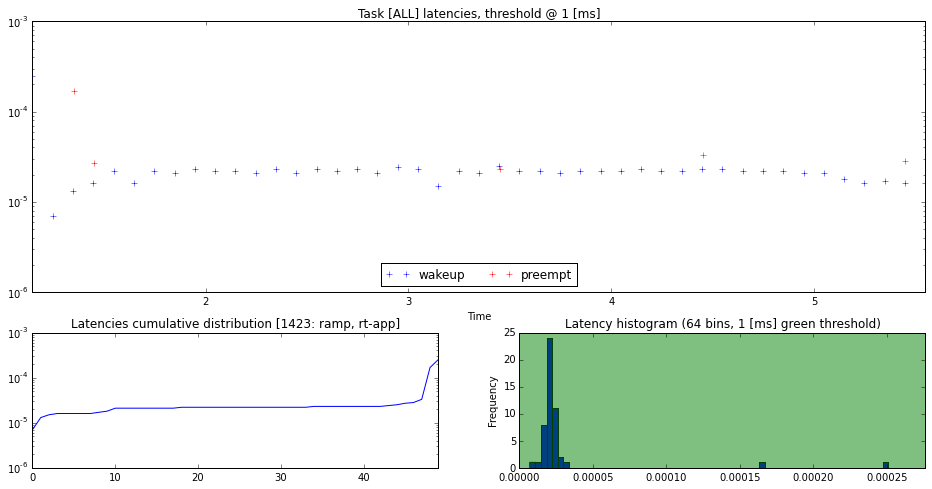

In [15]:
# Plot latency events for a specified task
latency_stats_df = trace.analysis.latency.plotLatency('ramp')

In [16]:
# Plot statistics on task latencies
latency_stats_df.T

,count,mean,std,min,50%,95%,99%,max
latency,50,0.000029,0.000038,0.000007,0.000022,0.000031,0.00021,0.000251


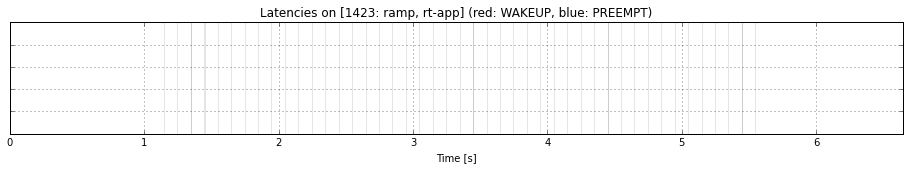

In [17]:
# Plot latency events for a specified task
trace.analysis.latency.plotLatencyBands('ramp')

10:25:42  INFO    : Set plots time range to (3.445000, 3.450000)[s]


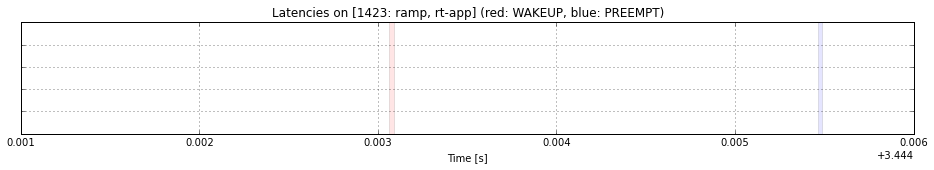

In [21]:
# Zoom into a spefific time frame
trace.setXTimeRange(3.445, 3.45)
trace.analysis.latency.plotLatencyBands('ramp')